# Data and library importing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import soundfile
import librosa

import numpy as np

import glob
import os

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

# Data loading and preprocessing

In [ ]:
def extract_feature(file_name):
    try:
        with soundfile.SoundFile(file_name) as sound_file:
            X = sound_file.read(dtype="float32")  # Read audio data
            sample_rate = sound_file.samplerate

        # Normalize the audio signal to the range [-1, 1]
        X = librosa.util.normalize(X)

        result = np.array([])

        # Short-Time Fourier Transform (STFT)
        stft = np.abs(librosa.stft(X))

        # MFCC (Mel-Frequency Cepstral Coefficients)
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
        result = np.hstack((result, mfccs))

        # Chroma Features
        chroma_features = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
        result = np.hstack((result, chroma_features))

        # Mel Spectrogram
        mel_spectrogram = np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T, axis=0)
        result = np.hstack((result, mel_spectrogram))

        return result

    except Exception as e:
        print(f"Error extracting features from {file_name}: {e}")
        return None

In [ ]:
def load_data_emodb(test_size=0.25):
    # W: Angry, F: Happy, T: Sad, N: Neutral
    int2emotion = { "W": 0, "F": 1, "T": 2, "N": 3 }
    AVAILABLE_EMOTIONS = {"W", "F", "T", "N"}

    X, y = [], []

    files = glob.glob("/content/drive/MyDrive/EmoDB/*.wav")
    print(f"Found {len(files)} audio files.")

    for file in files:
        try:
            basename = os.path.basename(file)
            print(f"Processing file: {basename}")

            emotion_key = basename[5]
            emotion = int2emotion.get(emotion_key, None)

            if emotion_key not in AVAILABLE_EMOTIONS:
                print(f"Skipping file: {basename} (emotion '{emotion_key}' not in AVAILABLE_EMOTIONS)")
                continue

            features = extract_feature(file)

            X.append(features)
            y.append(emotion)

        except Exception as e:
            print(f"Error processing file {file}: {e}")

    print(f"Total valid samples collected: {len(X)}")

    return train_test_split(np.array(X), y, test_size=test_size, random_state=7, stratify=y)

In [ ]:
X_train, X_test, y_train, y_test = load_data_emodb(test_size=0.25)
print("[+] Number of training samples:", X_train.shape[0])
print("[+] Number of testing samples:", X_test.shape[0])
print("[+] Number of features:", X_train.shape[1])

Found 564 audio files.
Processing file: 03a02Wb.wav
Processing file: 03a01Wa (2).wav
Processing file: 03a02Ta.wav
Processing file: 03a01Fa.wav
Processing file: 03a01Wa (1).wav
Processing file: 03a01Nc (1).wav
Processing file: 03a01Nc.wav
Processing file: 03a02Nc.wav
Processing file: 03a02Fc.wav
Processing file: 03a01Wa.wav
Processing file: 09a07Wd.wav
Processing file: 08b09Wc.wav
Processing file: 09a04Nb.wav
Processing file: 09a01Wb.wav
Processing file: 08a02Tb.wav
Processing file: 09b03Nb.wav
Processing file: 08a02La.wav
Skipping file: 08a02La.wav (emotion 'L' not in AVAILABLE_EMOTIONS)
Processing file: 08b10La.wav
Skipping file: 08b10La.wav (emotion 'L' not in AVAILABLE_EMOTIONS)
Processing file: 08b01Fe.wav
Processing file: 09a04Wa.wav
Processing file: 11a02Tc.wav
Processing file: 10b09Ad.wav
Skipping file: 10b09Ad.wav (emotion 'A' not in AVAILABLE_EMOTIONS)
Processing file: 08a05Wa.wav
Processing file: 03a07Nc.wav
Processing file: 03b02Na.wav
Processing file: 10a02Na.wav
Processing

# ML Models


##Decision Tree


Accuracy: 0.76
Precision: 0.75
Recall: 0.76
F1 Score: 0.75
AUC-ROC Score: 0.85


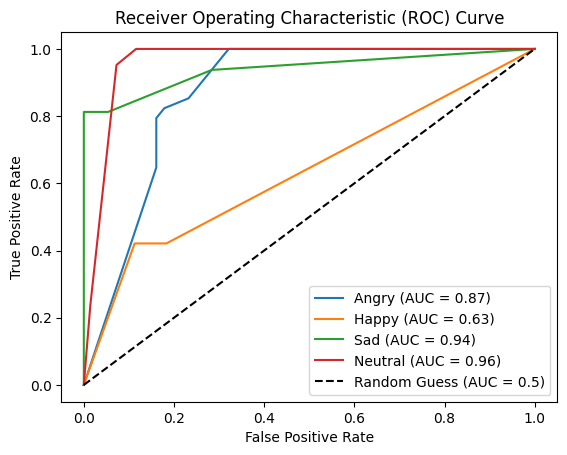

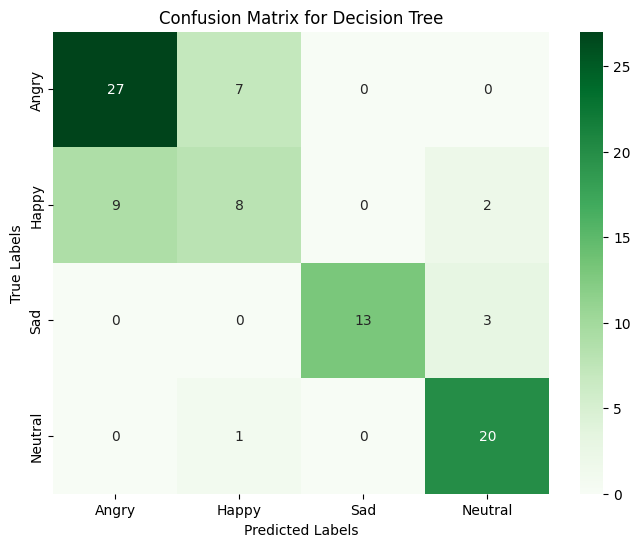

In [ ]:
# Create and train the Decision Tree classifier directly
dtree = DecisionTreeClassifier(max_depth=5, min_samples_split=2, min_samples_leaf=1)  # Example of parameters

# Fit the model to the training data
dtree.fit(X_train, y_train)

# Make predictions on the test set
dtree_predictions = dtree.predict(X_test)

# Calculate the metrics
accuracy = accuracy_score(y_test, dtree_predictions)
precision = precision_score(y_test, dtree_predictions, average='weighted')
recall = recall_score(y_test, dtree_predictions, average='weighted')
f1 = f1_score(y_test, dtree_predictions, average='weighted')

# For multi-class classification, calculate AUC-ROC
auc_roc = roc_auc_score(y_test, dtree.predict_proba(X_test), multi_class='ovr', average='weighted')

# Output the results
print(f"\nAccuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"AUC-ROC Score: {auc_roc:.2f}")

# Binarize the labels for ROC curve plotting
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])
n_classes = y_test_bin.shape[1]

# Emotion labels (assuming your classes are these)
emotion_labels = {0: 'Angry', 1: 'Happy', 2: 'Sad', 3: 'Neutral'}

# Plot ROC curve for each class
for i in range(n_classes):
    fpr_i, tpr_i, _ = roc_curve(y_test_bin[:, i], dtree.predict_proba(X_test)[:, i])
    auc_score = roc_auc_score(y_test_bin[:, i], dtree.predict_proba(X_test)[:, i])
    plt.plot(fpr_i, tpr_i, label=f'{emotion_labels[i]} (AUC = {auc_score:.2f})')

# Plotting the random guess line
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess (AUC = 0.5)')

# Labels and title for the plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Confusion matrix
conf_matrix_dt = confusion_matrix(y_test, dtree_predictions)

# Map the labels to emotions (same as before)
emotion_labels = ['Angry', 'Happy', 'Sad', 'Neutral']

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_dt, annot=True, fmt="d", cmap="Greens", xticklabels=emotion_labels, yticklabels=emotion_labels)

# Add labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Decision Tree')
plt.show()



## Support Vector Machines


Accuracy: 0.8778
Precision: 0.8830
Recall: 0.8778
F1 Score: 0.8779
AUC-ROC Score: 0.9778


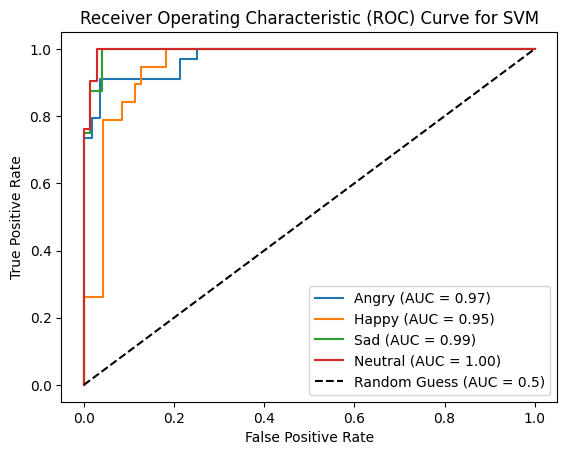

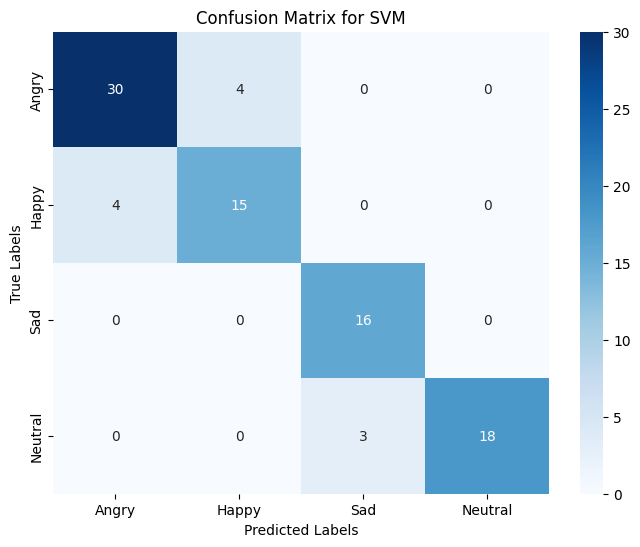

In [ ]:
# Initialize the SVC model (you can adjust the parameters directly)
svm_model = SVC(C=1, kernel='linear', probability=True)  # Enable probability estimates for AUC calculation

# Fit the model on the training data
svm_model.fit(X_train, y_train)

# Predict on the test set using the trained model
svm_predictions = svm_model.predict(X_test)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, svm_predictions)
precision = precision_score(y_test, svm_predictions, average='weighted')
recall = recall_score(y_test, svm_predictions, average='weighted')
f1 = f1_score(y_test, svm_predictions, average='weighted')
auc_roc = roc_auc_score(y_test, svm_model.predict_proba(X_test), multi_class='ovr', average='weighted')

# Output the metrics
print(f"\nAccuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC-ROC Score: {auc_roc:.4f}")

# Plot ROC curve for multi-class classification
emotion_labels = {0: 'Angry', 1: 'Happy', 2: 'Sad', 3: 'Neutral'}  # Define emotion labels
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])  # Assuming 4 classes
n_classes = y_test_bin.shape[1]

# Plot ROC curve for each class
for i in range(n_classes):
    fpr_i, tpr_i, _ = roc_curve(y_test_bin[:, i], svm_model.predict_proba(X_test)[:, i])
    auc_score = roc_auc_score(y_test_bin[:, i], svm_model.predict_proba(X_test)[:, i])
    plt.plot(fpr_i, tpr_i, label=f'{emotion_labels[i]} (AUC = {auc_score:.2f})')

# Plotting the random guess line
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess (AUC = 0.5)')

# Labels and title for the plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for SVM')
plt.legend(loc="lower right")
plt.show()

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, svm_predictions)

# Map the labels to emotions
emotion_labels = ['Angry', 'Happy', 'Sad', 'Neutral']

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=emotion_labels, yticklabels=emotion_labels)

# Add labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for SVM')
plt.show()


## Random Forest


Accuracy: 0.8667
Precision: 0.8757
Recall: 0.8667
F1 Score: 0.8621
AUC-ROC Score: 0.9802


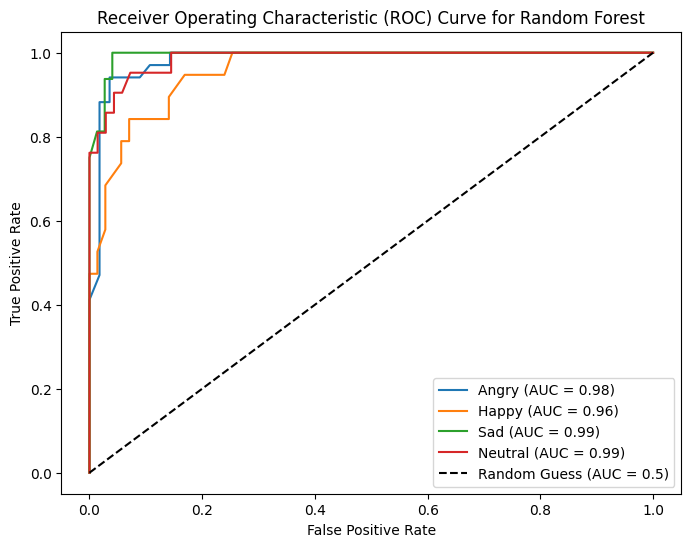

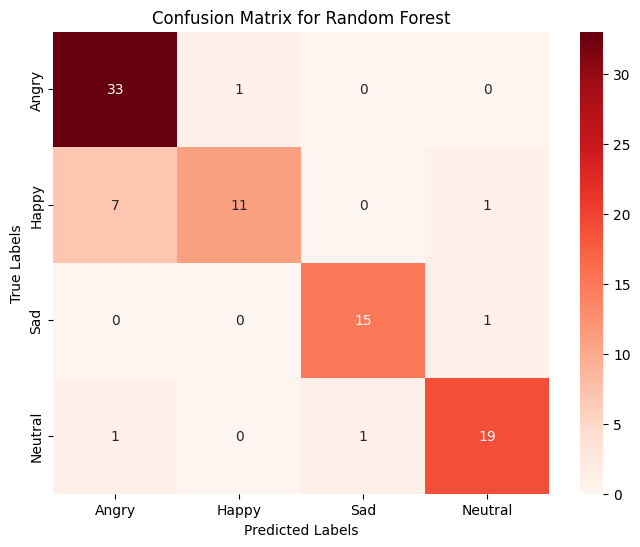

In [ ]:
# Create the RandomForest classifier (with default parameters)
classifier = RandomForestClassifier(n_estimators=100)

# Fit the classifier with training data
classifier.fit(X_train, y_train)

# Predict on the test set
c_p = classifier.predict(X_test)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, c_p)
precision = precision_score(y_test, c_p, average='weighted')
recall = recall_score(y_test, c_p, average='weighted')
f1 = f1_score(y_test, c_p, average='weighted')
auc_roc = roc_auc_score(y_test, classifier.predict_proba(X_test), multi_class='ovr', average='weighted')

# Output the metrics
print(f"\nAccuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC-ROC Score: {auc_roc:.4f}")

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    fpr_i, tpr_i, _ = roc_curve(y_test_bin[:, i], classifier.predict_proba(X_test)[:, i])
    auc_score = roc_auc_score(y_test_bin[:, i], classifier.predict_proba(X_test)[:, i])
    plt.plot(fpr_i, tpr_i, label=f'{emotion_labels[i]} (AUC = {auc_score:.2f})')

# Plotting the random guess line
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess (AUC = 0.5)')

# Labels and title for the plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Random Forest')
plt.legend(loc="lower right")
plt.show()

# Emotion Labels
emotion_labels = ['Angry', 'Happy', 'Sad', 'Neutral']

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf, annot=True, fmt="d", cmap="Reds", xticklabels=emotion_labels, yticklabels=emotion_labels)

# Add labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Random Forest')
plt.show()

# Plot ROC curve for multi-class classification
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])  # Assuming 4 classes
n_classes = y_test_bin.shape[1]

## Naive Bayes


Accuracy: 0.8444
Precision: 0.8448
Recall: 0.8444
F1 Score: 0.8371
AUC-ROC Score: 0.9468


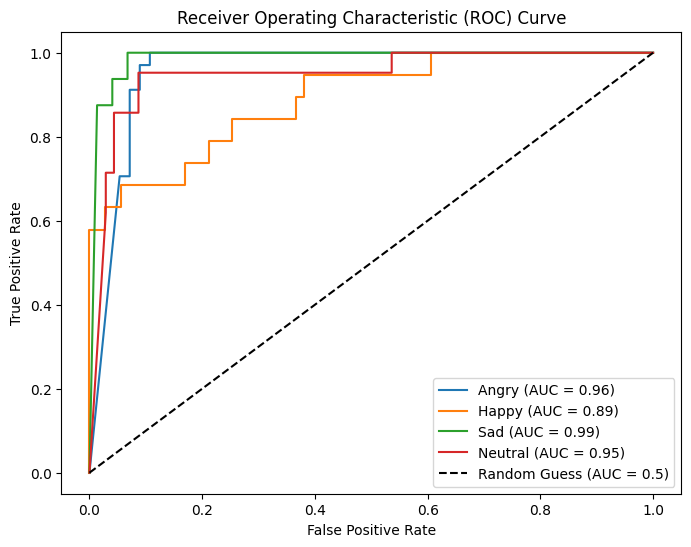

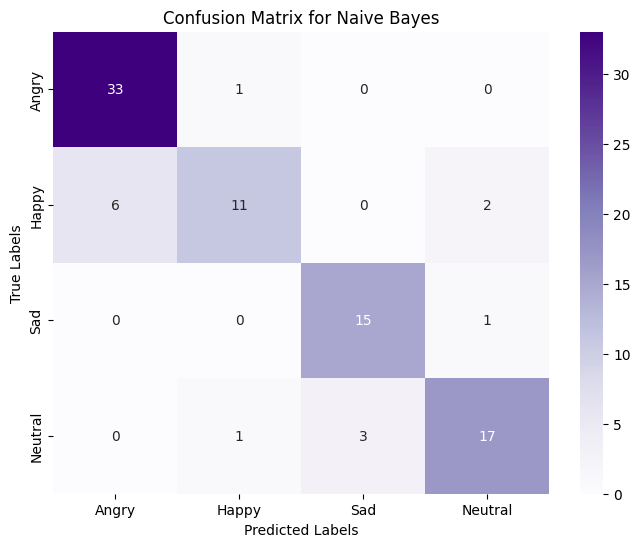

In [ ]:
# Initialize the Naive Bayes classifier
nb_classifier = GaussianNB()

# Train the classifier
nb_classifier.fit(X_train, y_train)

# Make predictions
nb_predictions = nb_classifier.predict(X_test)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, nb_predictions)
precision = precision_score(y_test, nb_predictions, average='weighted')
recall = recall_score(y_test, nb_predictions, average='weighted')
f1 = f1_score(y_test, nb_predictions, average='weighted')
auc_roc = roc_auc_score(y_test, nb_classifier.predict_proba(X_test), multi_class='ovr', average='weighted')

# Output the metrics
print(f"\nAccuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC-ROC Score: {auc_roc:.4f}")

# Compute ROC Curve and AUC for multi-class classification
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])  # Adjust according to the number of classes
n_classes = y_test_bin.shape[1]

# Plot ROC Curve for each class
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], nb_classifier.predict_proba(X_test)[:, i])
    auc = roc_auc_score(y_test_bin[:, i], nb_classifier.predict_proba(X_test)[:, i])
    plt.plot(fpr, tpr, label=f'{emotion_labels[i]} (AUC = {auc:.2f})')

# Plot the random guess line
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess (AUC = 0.5)')

# Add plot labels and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, nb_predictions)
emotion_labels = ['Angry', 'Happy', 'Sad', 'Neutral']  # Adjust based on your dataset

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Purples", xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Naive Bayes')
plt.show()




## K Neighbours


Accuracy: 0.7778
Precision: 0.7856
Recall: 0.7778
F1 Score: 0.7755
AUC-ROC Score: 0.9262


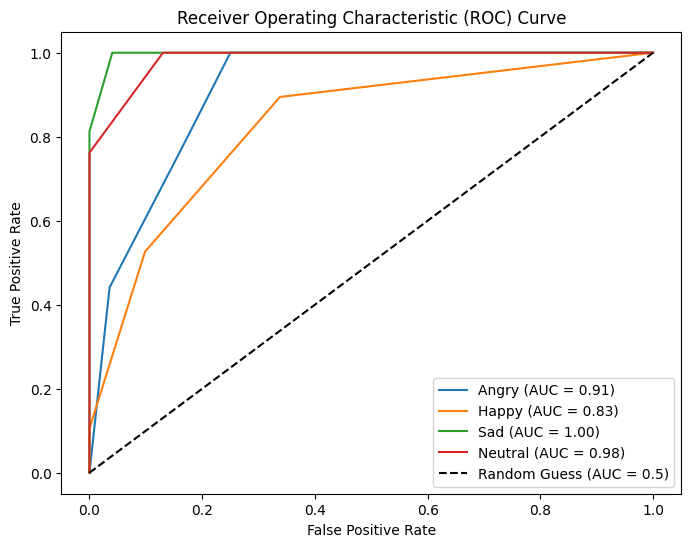

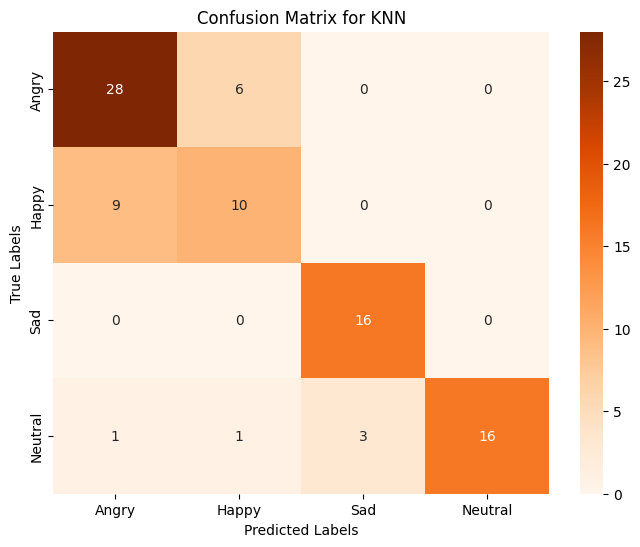

In [ ]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the KNN classifier
k = 3  # You can experiment with different values of k
knn_classifier = KNeighborsClassifier(n_neighbors=k)

# Train the classifier
knn_classifier.fit(X_train_scaled, y_train)

# Make predictions
knn_predictions = knn_classifier.predict(X_test_scaled)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, knn_predictions)
precision = precision_score(y_test, knn_predictions, average='weighted')
recall = recall_score(y_test, knn_predictions, average='weighted')
f1 = f1_score(y_test, knn_predictions, average='weighted')

# Check if predict_proba is supported
try:
    auc_roc = roc_auc_score(
        y_test,
        knn_classifier.predict_proba(X_test_scaled),
        multi_class='ovr',
        average='weighted'
    )
except AttributeError:
    auc_roc = None  # KNN doesn't have `predict_proba` when it's not fitted with probabilities
    print("AUC-ROC could not be computed as KNeighborsClassifier lacks `predict_proba` by default.")

# Output metrics
print(f"\nAccuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
if auc_roc is not None:
    print(f"AUC-ROC Score: {auc_roc:.4f}")


# Plot ROC Curve
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])  # Adjust based on your dataset
n_classes = y_test_bin.shape[1]
emotion_labels = {0: 'Angry', 1: 'Happy', 2: 'Sad', 3: 'Neutral'}  # Adjust labels

plt.figure(figsize=(8, 6))
for i in range(n_classes):
    try:
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], knn_classifier.predict_proba(X_test_scaled)[:, i])
        auc = roc_auc_score(y_test_bin[:, i], knn_classifier.predict_proba(X_test_scaled)[:, i])
        plt.plot(fpr, tpr, label=f'{emotion_labels[i]} (AUC = {auc:.2f})')
    except AttributeError:
        print("Skipping AUC-ROC computation for KNN without probabilities.")
        break

# Plotting the random guess line
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess (AUC = 0.5)')

# Add labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, knn_predictions)

# Map labels to emotions
emotion_labels = ['Angry', 'Happy', 'Sad', 'Neutral']

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Oranges", xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for KNN')
plt.show()



# Accuracy Comparison

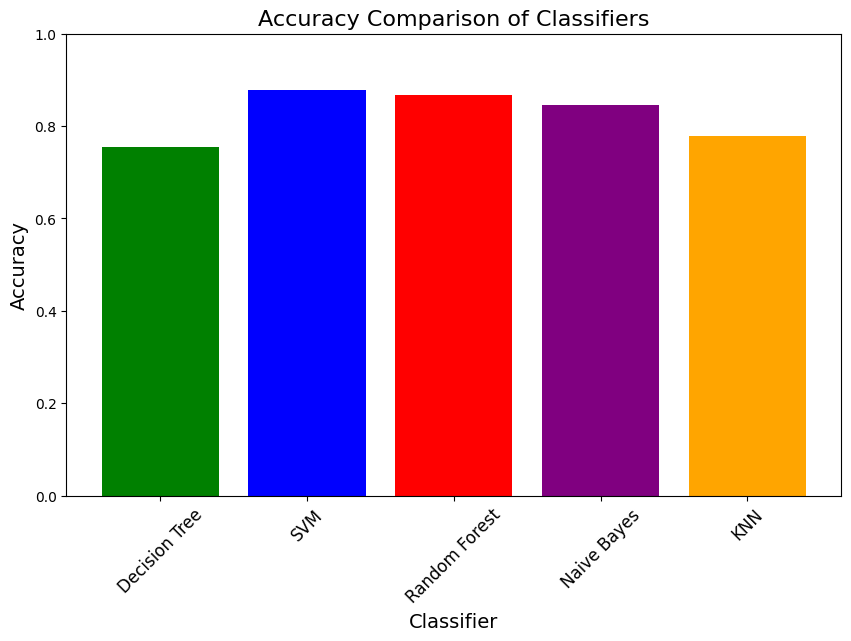

In [ ]:
# Accuracy scores from all classifiers
results = {
    'Decision Tree': accuracy_score(y_test, dtree_predictions),
    'SVM': accuracy_score(y_test, svm_predictions),
    'Random Forest': accuracy_score(y_test, c_p),
    'Naive Bayes': accuracy_score(y_test, nb_predictions),
    'KNN': accuracy_score(y_test, knn_predictions)
}

# Plot the accuracies
plt.figure(figsize=(10, 6))
plt.bar(results.keys(), results.values(), color=['green', 'blue', 'red', 'purple', 'orange'])
plt.title('Accuracy Comparison of Classifiers', fontsize=16)
plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('Classifier', fontsize=14)
plt.ylim(0, 1)
plt.xticks(rotation=45, fontsize=12)
plt.show()

Precision, Recall and F1

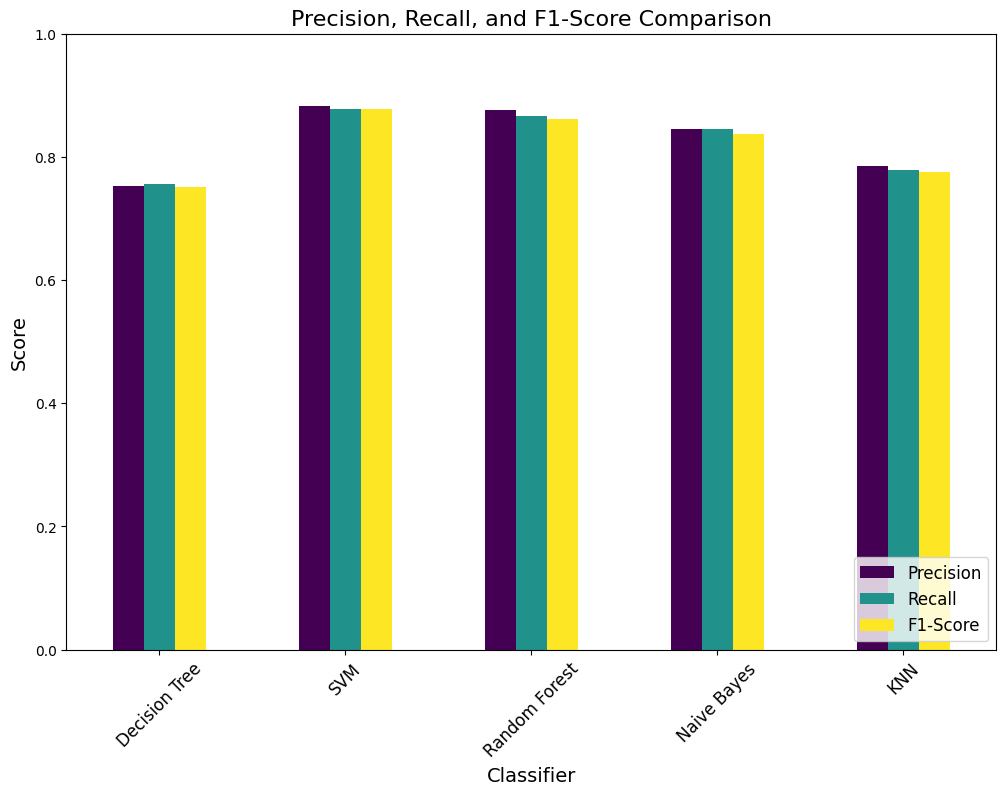

In [ ]:
# Extract precision, recall, and F1-score
metrics = {}
for name, preds in zip(['Decision Tree', 'SVM', 'Random Forest', 'Naive Bayes', 'KNN'],
                       [dtree_predictions, svm_predictions, c_p, nb_predictions, knn_predictions]):
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, preds, average='weighted', zero_division=0)
    metrics[name] = {'Precision': precision, 'Recall': recall, 'F1-Score': f1}

# Convert to DataFrame for plotting
import pandas as pd
metrics_df = pd.DataFrame(metrics).T

# Plot
metrics_df.plot(kind='bar', figsize=(12, 8), colormap='viridis')
plt.title('Precision, Recall, and F1-Score Comparison', fontsize=16)
plt.ylabel('Score', fontsize=14)
plt.xlabel('Classifier', fontsize=14)
plt.ylim(0, 1)
plt.xticks(rotation=45, fontsize=12)
plt.legend(loc='lower right', fontsize=12)
plt.show()